# Nanosecond extraction

In [1]:
from datetime import datetime, date
import ibis
import numpy as np
import pandas as pd
# local
from settings import conf
from utils import cursor2df
from gen_data import salary_date, salary_date_schema

ibis.options.interactive = False

In [2]:
# nanosecond example:
# np.datetime64('2010-02-28T02:03:01.123412344')

### Setup

In [3]:
BACKENDS = ['omniscidb']
con = {
    backend: getattr(ibis, backend).connect(**conf[backend]) 
    for backend in BACKENDS
}

In [4]:
df_salary1 = salary_date()
print(df_salary1.dtypes)
df_salary1.info()

last_name                     object
salary                       float64
date_of_birth                 object
timestamp_of_birth    datetime64[ns]
dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4018 entries, 0 to 4017
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   last_name           4018 non-null   object        
 1   salary              4018 non-null   float64       
 2   date_of_birth       4018 non-null   object        
 3   timestamp_of_birth  4018 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 125.7+ KB


In [5]:
sch = salary_date_schema()
sch

ibis.Schema {  
  last_name           string
  salary              float64
  date_of_birth       date
  timestamp_of_birth  timestamp
}

In [6]:
def get_sample(df):
    return df.head(10000).tail(5)

sample = get_sample(df_salary1)
sample

,last_name,salary,date_of_birth,timestamp_of_birth
4013,Name 2016 12 31,2016151.0,2016-12-31,2016-12-31 12:12:12.012012031
4014,Name 2017 12 31,2017151.0,2017-12-31,2017-12-31 12:12:12.012012031
4015,Name 2018 12 31,2018151.0,2018-12-31,2018-12-31 12:12:12.012012031
4016,Name 2019 12 31,2019151.0,2019-12-31,2019-12-31 12:12:12.012012031
4017,Name 2020 12 31,2020151.0,2020-12-31,2020-12-31 12:12:12.012012031


In [7]:
sample.timestamp_of_birth.dt.nanosecond

4013    31
4014    31
4015    31
4016    31
4017    31
Name: timestamp_of_birth, dtype: int64

In [8]:
se_epoch = sample.timestamp_of_birth.astype(int)
se_epoch

4013    1483186332012012031
4014    1514722332012012031
4015    1546258332012012031
4016    1577794332012012031
4017    1609416732012012031
Name: timestamp_of_birth, dtype: int64

In [9]:
def epoch_to_datetime64(epoch):
    dt = datetime.fromtimestamp(epoch / 1e9)
    dt_str = '{}{:03.0f}'.format(dt.strftime('%Y-%m-%dT%H:%M:%S.%f'), epoch % 1e3)
    return np.datetime64(dt_str)

epoch_to_datetime64(1483186332012012031)

numpy.datetime64('2016-12-31T08:12:12.012012032')

In [10]:
np.datetime64(1483186332012012031, 'ns')

numpy.datetime64('2016-12-31T12:12:12.012012031')

In [11]:
table_name = 'salary_epoch'
t = {}
params = {
    'omniscidb': {},
    'postgres': {'if_exists': 'append'}
}

def create_table(con):
    sql = '''
    CREATE TABLE {} (
        last_name TEXT,
        salary DOUBLE,
        date_of_birth DATE,
        timestamp_of_birth TIMESTAMP(9)
    )'''.format(table_name)
    con.execute(sql)
    

def load_table(con):
    sql = '''
    INSERT INTO {0} ({1}) VALUES ('Name 2016 12 31', 2016151.0, '2016-12-31', '2016-12-31 12:12:12.012012031');
    INSERT INTO {0} ({1}) VALUES ('Name 2017 12 31', 2017151.0, '2017-12-31', '2017-12-31 12:12:12.012012031');
    INSERT INTO {0} ({1}) VALUES ('Name 2018 12 31', 2018151.0, '2018-12-31', '2018-12-31 12:12:12.012012031');
    INSERT INTO {0} ({1}) VALUES ('Name 2019 12 31', 2019151.0, '2019-12-31', '2019-12-31 12:12:12.012012031');
    INSERT INTO {0} ({1}) VALUES ('Name 2020 12 31', 2020151.0, '2020-12-31', '2020-12-31 12:12:12.012012031');
    '''.format(table_name, 'last_name, salary, date_of_birth, timestamp_of_birth')
    
    for row in sql.split('\n'):
        if 'INSERT' not in row:
            continue
        print(row)
        con.execute(row)

for backend in BACKENDS:
    if hasattr(con[backend], 'load_data'):
        con[backend].drop_table(table_name, force=True)
        # con[backend].create_table(table_name, schema=sch)
        create_table(con[backend].con)
        load_table(con[backend].con)
        # con[backend].load_data(table_name, df_salary1, **params[backend])
    t[backend] = con[backend].table(table_name)

    INSERT INTO salary_epoch (last_name, salary, date_of_birth, timestamp_of_birth) VALUES ('Name 2016 12 31', 2016151.0, '2016-12-31', '2016-12-31 12:12:12.012012031');
    INSERT INTO salary_epoch (last_name, salary, date_of_birth, timestamp_of_birth) VALUES ('Name 2017 12 31', 2017151.0, '2017-12-31', '2017-12-31 12:12:12.012012031');
    INSERT INTO salary_epoch (last_name, salary, date_of_birth, timestamp_of_birth) VALUES ('Name 2018 12 31', 2018151.0, '2018-12-31', '2018-12-31 12:12:12.012012031');
    INSERT INTO salary_epoch (last_name, salary, date_of_birth, timestamp_of_birth) VALUES ('Name 2019 12 31', 2019151.0, '2019-12-31', '2019-12-31 12:12:12.012012031');
    INSERT INTO salary_epoch (last_name, salary, date_of_birth, timestamp_of_birth) VALUES ('Name 2020 12 31', 2020151.0, '2020-12-31', '2020-12-31 12:12:12.012012031');


In [12]:
sql = t['omniscidb'].head().compile()

cur = con['omniscidb'].con.execute(sql)

for row in cur.description:
    print(row)

for row in cur:
    print(row)

Description(name='last_name', type_code=6, display_size=None, internal_size=None, precision=None, scale=None, null_ok=True)
Description(name='salary', type_code=5, display_size=None, internal_size=None, precision=None, scale=None, null_ok=True)
Description(name='date_of_birth', type_code=9, display_size=None, internal_size=None, precision=None, scale=None, null_ok=True)
Description(name='timestamp_of_birth', type_code=8, display_size=None, internal_size=None, precision=None, scale=None, null_ok=True)
('Name 2016 12 31', 2016151.0, datetime.date(2016, 12, 31), numpy.datetime64('2016-12-31T12:12:12.012012031'))
('Name 2017 12 31', 2017151.0, datetime.date(2017, 12, 31), numpy.datetime64('2017-12-31T12:12:12.012012031'))
('Name 2018 12 31', 2018151.0, datetime.date(2018, 12, 31), numpy.datetime64('2018-12-31T12:12:12.012012031'))
('Name 2019 12 31', 2019151.0, datetime.date(2019, 12, 31), numpy.datetime64('2019-12-31T12:12:12.012012031'))
('Name 2020 12 31', 2020151.0, datetime.date(2020,

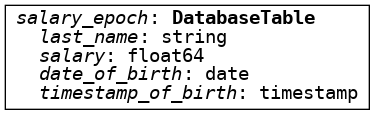

In [13]:
con['omniscidb'].table(table_name)

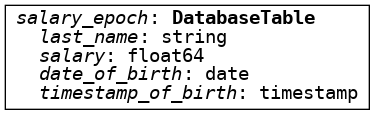

In [14]:
t['omniscidb']

In [15]:
t['omniscidb'].execute().head()

,last_name,salary,date_of_birth,timestamp_of_birth
0,Name 2016 12 31,2016151.0,2016-12-31,2016-12-31 12:12:12.012012031
1,Name 2017 12 31,2017151.0,2017-12-31,2017-12-31 12:12:12.012012031
2,Name 2018 12 31,2018151.0,2018-12-31,2018-12-31 12:12:12.012012031
3,Name 2019 12 31,2019151.0,2019-12-31,2019-12-31 12:12:12.012012031
4,Name 2020 12 31,2020151.0,2020-12-31,2020-12-31 12:12:12.012012031


In [16]:
sql = t['omniscidb'].head().compile()

cur = con['omniscidb'].con.execute(sql)

for row in cur:
    print(row)
    
print(cur.description)

('Name 2016 12 31', 2016151.0, datetime.date(2016, 12, 31), numpy.datetime64('2016-12-31T12:12:12.012012031'))
('Name 2017 12 31', 2017151.0, datetime.date(2017, 12, 31), numpy.datetime64('2017-12-31T12:12:12.012012031'))
('Name 2018 12 31', 2018151.0, datetime.date(2018, 12, 31), numpy.datetime64('2018-12-31T12:12:12.012012031'))
('Name 2019 12 31', 2019151.0, datetime.date(2019, 12, 31), numpy.datetime64('2019-12-31T12:12:12.012012031'))
('Name 2020 12 31', 2020151.0, datetime.date(2020, 12, 31), numpy.datetime64('2020-12-31T12:12:12.012012031'))
[Description(name='last_name', type_code=6, display_size=None, internal_size=None, precision=None, scale=None, null_ok=True), Description(name='salary', type_code=5, display_size=None, internal_size=None, precision=None, scale=None, null_ok=True), Description(name='date_of_birth', type_code=9, display_size=None, internal_size=None, precision=None, scale=None, null_ok=True), Description(name='timestamp_of_birth', type_code=8, display_size=Non

In [17]:
_t = t['omniscidb']

In [18]:
expr = _t.timestamp_of_birth.nanosecond().name('tmp')
expr = _t[_t.timestamp_of_birth, expr]
print(expr.compile())
expr.execute();

AttributeError: 'TimestampColumn' object has no attribute 'nanosecond'

## Tests

In [25]:
d = np.datetime64('2010-01-01 01:01:01.001001001')

True

In [72]:
int(d.view('i8'))

1262307661001001001

In [74]:
np.datetime64(1262307661001001001, 'ns')

numpy.datetime64('2010-01-01T01:01:01.001001001')

In [ ]:
# pd.testing.assert_frame_equal(t['omniscidb'].execute(), t['postgres'].execute())

In [ ]:
df = expr.execute()
df

### 1. Nanosecond and epoch

#### Compare 2 pandas approach for epoch

In [ ]:
expected_1 = pd.Series(
    (pd.DatetimeIndex(df.timestamp_of_birth) - pd.Timestamp('1970-01-01'))
    // pd.Timedelta('1s')
)

expected_2 = df.timestamp_of_birth.astype(int) // int(1e9)
pd.testing.assert_series_equal(expected_1, expected_2)

In [ ]:
for b in BACKENDS:
    try:
        print(' {} '.format(b).center(80, '='))
        expr = t[b].timestamp_of_birth.nanosecond()
        result = expr.execute()
        expected = df.timestamp_of_birth.dt.nanosecond
        print(expr.compile())
        print('.' * 80)
        pd.testing.assert_series_equal(result, expected, check_names=False, check_dtype=False)
    except ibis.common.exceptions.OperationNotDefinedError:
        print('[WW] Not implemented')
    except AssertionError as e:
        print('[EE] AssertionError (left=result, right=expected)')
        print(e)

In [103]:
np.datetime64(1262307661001001001, 'ns').astype(str)

'2010-01-01T01:01:01.001001001'

In [104]:
np.datetime64("2010-01-01T01:01:01.001001001")

numpy.datetime64('2010-01-01T01:01:01.001001001')